# Yelp Review Analysis - Korean Restaurants

<p style="font-size:20px;">Daniel Cho</p>

## Introduction

In a research study conducted by Michael Luca, an assistant professor at Harvard Business School, has shown that there is a strong correlation between Yelp ratings and revenue for restaurants. In fact, his study found that a mere one-star increase in Yelp rating can result in a notable 5-9 percent increase in revenue. This demonstrates the significant influence that Yelp, as a popular platform, holds over consumers' decision-making processes when it comes to choosing dining establishments.

Motivated by these findings, I became interested in utilizing natural language processing (NLP) and text analysis methods to potentially improve the business performance of my mother's Korean restaurant. By analyzing the text content of customer reviews, I aim to gain valuable insights into their sentiments, preferences, and areas for improvement. Moreover, the same approach can be applied to other restaurants as well, enabling owners to leverage the power of NLP to enhance their understanding of customer feedback and make data-driven decisions for business growth.

In [1]:
#load required packages
import re
from collections import Counter, defaultdict
import nltk
import numpy as np
import pandas as pd
from cytoolz import concat
from tqdm.auto import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import DocBin
tqdm.pandas()

In [2]:
df = pd.read_csv('review_yelp.csv')

In [3]:
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,category,review_id,user_id,review_star,date,text,useful,funny,cool
0,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221.0,41.119535,-81.47569,3.5,116,1,American,rnvu74aNIPn93Z9Ue11Epw,bgtr7jOlALe8ay4g7pnf4A,4,2016-05-05,I've always enjoyed my time at brick house foo...,0,0,0
1,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221.0,41.119535,-81.47569,3.5,116,1,American,OE5dH664oSSK_-TvIl263w,ndZOHkG_FWdL4TRd9xRfNQ,2,2017-03-19,1st time here. Came w my Unc bc Louies was clo...,0,0,0
2,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221.0,41.119535,-81.47569,3.5,116,1,American,SWeHmo8uHHWbbv94VdAMeQ,UqtE83J-6NMQNNJzpnWwEQ,1,2015-08-31,Worse service ever andI use to be a server so ...,0,0,0
3,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221.0,41.119535,-81.47569,3.5,116,1,American,fCCL0pAgYGccUs8shHHIUA,PixAmdRa58XZ3hr8YLS36g,5,2015-10-09,I am updating my review to 5-stars because I t...,2,0,2
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221.0,41.119535,-81.47569,3.5,116,1,American,-VOh0NNnIo1r24hjwSZL4Q,Hly0NEWXMxbuXa2zm_NJOQ,4,2015-01-15,I enjoyed this place. I went the night the Bu...,0,0,0


In [4]:
np.unique(df['category'])

array(['African', 'American', 'Chinese', 'French', 'Greek', 'Hawaiian',
       'Indian', 'Italian', 'Japanese', 'Korean', 'Mediterranean',
       'Mexican', 'Spanish', 'Thai', 'Vietnamese'], dtype=object)

In [5]:
#create new dataframe with korean category
krn = df[df.category == 'Korean']

In [6]:
krn["avg_star"].value_counts()

4.0    12346
4.5    11580
3.5     8921
3.0     4194
2.5     1118
2.0       89
5.0       69
1.5        3
Name: avg_star, dtype: int64

## Exploratory Data Analysis

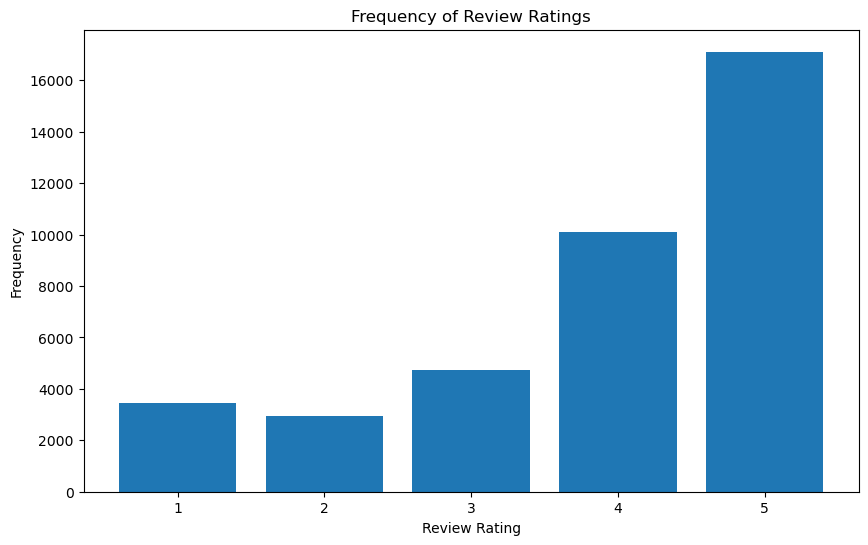

In [7]:
plt.figure(figsize=(10,6))
star_counts = krn['review_star'].value_counts().sort_index()

plt.bar(star_counts.index, star_counts.values)

# Set plot labels and title
plt.xlabel('Review Rating')
plt.ylabel('Frequency')
plt.title('Frequency of Review Ratings')

# Display the plot
plt.show()

We can see that there is a higher frequency of positively rated reviews(4/5), which might suggest that customers tend to only write reviews if they had a positive experience. We will label reviews as positive or negative based on their respective star rating to explore our data further.

In [8]:
krn["sentiment"] = ''
krn.loc[krn.review_star >= 4, "sentiment"] = 'positive'
krn.loc[krn.review_star <= 3, "sentiment"] = 'negative'

/tmp/ipykernel_847677/205406073.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  krn["sentiment"] = ''


/tmp/ipykernel_847677/2082232951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  krn['review_length'] = krn['text'].apply(lambda x: len(x.split()))


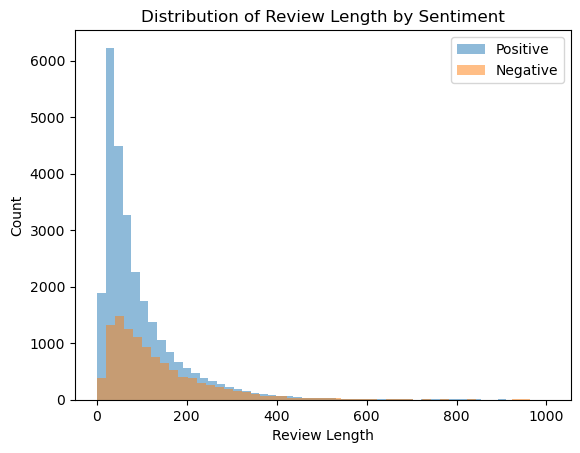

In [9]:
# Calculate the length of each review
krn['review_length'] = krn['text'].apply(lambda x: len(x.split()))

# Separate positive and negative reviews
positive_reviews = krn[krn['sentiment'] == 'positive']
negative_reviews = krn[krn['sentiment'] == 'negative']

# Plot the review length for positive reviews
plt.hist(positive_reviews['review_length'], bins=50, alpha=0.5, label='Positive')
# Plot the review length for negative reviews
plt.hist(negative_reviews['review_length'], bins=50, alpha=0.5, label='Negative')

# Add labels and title
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.title('Distribution of Review Length by Sentiment')

plt.legend()
plt.show()

We can see that customers tend to write short reviews with less than 100 words for both negative and positive sentiment. We can also see that there isn't a noticeable difference in the length of reviews between the two sentiments.

From the spacy library, we will load the English language model.

In [10]:
nlp = spacy.load("en_core_web_sm", exclude = ["ner"])

We will initialize the matcher object and add a custom speech pattern. We will then define our get_phrases function to take a document as an input and extract the patterns as defined in matcher.

In [11]:
matcher = Matcher(nlp.vocab)
matcher.add(
    "Term",
    [
        [
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP"]}},
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP", "HYPH"]}, "OP": "*"},
            {"TAG": {"IN": ["NN", "NNS", "NNP"]}},
        ]
    ],
)


def get_phrases(doc):
    spans = matcher(doc, as_spans=True)
    return [tuple(tok.norm_ for tok in span) for span in spans]

### Find Candidate Terms

In [12]:
docs=nlp.pipe(tqdm(krn['text']), n_process=4)
candidates = Counter(concat(get_phrases(d) for d in docs))

  0%|          | 0/38320 [00:00<?, ?it/s]

In [13]:
candidates.most_common(10)

[(('korean', 'bbq'), 5863),
 (('korean', 'food'), 4282),
 (('side', 'dishes'), 3031),
 (('pork', 'belly'), 2837),
 (('first', 'time'), 2392),
 (('las', 'vegas'), 1471),
 (('korean', 'restaurant'), 1441),
 (('tofu', 'soup'), 1423),
 (('customer', 'service'), 1324),
 (('next', 'time'), 1294)]

In [14]:
freqs = defaultdict(Counter)
for c in candidates:
    freqs[len(c)][c] += candidates[c]

In [15]:
def get_subterms(term):
    k = len(term)
    for m in range(k - 1, 1, -1):
        yield from nltk.ngrams(term, m)


def c_value(F, theta):

    termhood = Counter()
    longer = defaultdict(list)

    for k in sorted(F, reverse=True):
        for term in F[k]:
            if term in longer:
                discount = sum(longer[term]) / len(longer[term])
            else:
                discount = 0
            c = np.log2(k) * (F[k][term] - discount)
            if c > theta:
                termhood[term] = c
                for subterm in get_subterms(term):
                    if subterm in F[len(subterm)]:
                        longer[subterm].append(F[k][term])
    return termhood

In [16]:
terms = c_value(freqs, theta = 50)

In [17]:
terms.most_common(10)

[(('korean', 'bbq'), 5745.32),
 (('korean', 'food'), 4156.571428571428),
 (('side', 'dishes'), 2971.8333333333335),
 (('pork', 'belly'), 2786.6),
 (('first', 'time'), 2359.0),
 (('las', 'vegas'), 1471.0),
 (('korean', 'restaurant'), 1375.5),
 (('tofu', 'soup'), 1324.6),
 (('next', 'time'), 1294.0),
 (('customer', 'service'), 1227.0)]

We can see that the most common terms that are used to describe aspects of a korean restaurant.

In [18]:
terms.most_common()[-10:]

[(('crab', 'meat'), 51.0),
 (('sushi', 'cafe'), 51.0),
 (('ftr', 'ftr', 'ftr', 'ftr', 'ftr', 'ftr', 'ftr', 'ftr', 'ftr'),
  50.718800023076994),
 (('korean', 'bbq', 'fix'), 50.718800023076994),
 (('=', '=', '='), 50.718800023076994),
 (('cafe', 'ga', 'hyang'), 50.718800023076994),
 (('favorite', 'sushi', 'place'), 50.718800023076994),
 (('pork', 'belly', 'benedict'), 50.718800023076994),
 (('ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   'ozzy',
   '

We will keep the theta threshold at 50 since the terms at the bottom of the list starts to describe features that are not related to Korean restaurants.

In [19]:
#save terms
with open("terms.txt", "w") as f:
    for term in terms:
        print(" ".join(term), file = f)

In [20]:
from spacy.matcher import PhraseMatcher
from spacy.util import filter_spans

phraser = PhraseMatcher(nlp.vocab, attr = "LOWER")

with open('terms.txt', 'r') as f:
    phraser.add("TERM", [nlp.tokenizer(t.strip()) for t in f])

In [21]:
def tokenize(text, sep="_"):
    doc = nlp.tokenizer(text)
    with doc.retokenize() as r:
        for span in filter_spans(phraser(doc, as_spans=True)):
            r.merge(span)
    return [t.norm_.replace(" ", sep) for t in doc if not t.is_space and not t.is_punct]

We will now tokenize texts using the terms we just found that is stored in our text file utilizing our phrase matcher and tokenize function.

In [22]:
krn["docs"] = [tokenize(txt) for txt in tqdm(krn["text"])]

  0%|          | 0/38320 [00:00<?, ?it/s]

/tmp/ipykernel_847677/348809430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  krn["docs"] = [tokenize(txt) for txt in tqdm(krn["text"])]


In [23]:
from nltk import FreqDist
from nltk import BigramAssocMeasures
metrics = BigramAssocMeasures()

In [24]:
bad_value = FreqDist(concat(krn.query('review_star < 4')['text'].apply(tokenize)))
total_value = FreqDist(concat(krn['text'].apply(tokenize)))

In [25]:
bad_llr = FreqDist()
bad_pmi = FreqDist()

for w in bad_value:
    if bad_value[w] > 10:
        bad_llr[w] = metrics.likelihood_ratio(bad_value[w], (total_value[w], bad_value.N()), total_value.N())
        bad_pmi[w] = metrics.pmi(bad_value[w], (total_value[w], bad_value.N()), total_value.N())

In [26]:
bad_llr.most_common(10)

[('not', 3535.8322849046726),
 ('delicious', 2779.5624489570355),
 ('great', 1953.630643688054),
 ('amazing', 1846.233925140954),
 ('definitely', 1819.6874331409367),
 ('is', 1796.0842553158054),
 ('love', 1793.226064883699),
 ('she', 1464.2689594163526),
 ('and', 1386.1714896006924),
 ('asked', 1298.91690795176)]

In [27]:
bad_pmi.most_common(10)

[('unacceptable', 1.4257103025880333),
 ('only_good_thing', 1.4257103025880333),
 ('roaches', 1.4257103025880333),
 ('proceeds', 1.4257103025880333),
 ('appalling', 1.4257103025880333),
 ('vomit', 1.4257103025880333),
 ('15min', 1.4257103025880333),
 ('vomiting', 1.4257103025880333),
 ('condescending', 1.4257103025880333),
 ('roks', 1.4257103025880333)]

In [28]:
good_value = FreqDist(concat(krn.query('review_star >= 4')['text'].apply(tokenize)))

good_llr = FreqDist()
good_pmi = FreqDist()

for w in good_value:
    if good_value[w] > 5:
        good_llr[w] = metrics.likelihood_ratio(good_value[w], (total_value[w], good_value.N()), total_value.N())
        good_pmi[w] = metrics.pmi(good_value[w], (total_value[w], good_value.N()), total_value.N())

In [29]:
good_llr.most_common(10)

[('not', 3535.832284904671),
 ('delicious', 2779.5624489570355),
 ('great', 1953.6306436880545),
 ('amazing', 1846.2339251409537),
 ('definitely', 1819.6874331409372),
 ('is', 1796.0842553158054),
 ('love', 1793.226064883699),
 ('she', 1464.268959416353),
 ('and', 1386.1714896006924),
 ('asked', 1298.9169079517599)]

In [30]:
good_pmi.most_common(10)

[('alodia', 0.6717059173330817),
 ('kailin', 0.6717059173330817),
 ('little_gem', 0.6717059173330817),
 ('projector', 0.6717059173330817),
 ('17.95', 0.6717059173330817),
 ('seong', 0.6717059173330817),
 ('tim', 0.6717059173330817),
 ('socialize', 0.6717059173330817),
 ('doubts', 0.6717059173330817),
 ('laura', 0.6717059173330817)]

### Word Cloud

Let's create two different statistical measures: log likelihood ratio and point mutual information to explore different aspects of word associations to gain insights to the text of both "bad" and "good" reviews.

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [32]:
def cloud(freqs, k=50):
    plt.figure(figsize = (8,8))
    wc = WordCloud(width = 750,
                height = 750,
                background_color = 'black').generate_from_frequencies(freqs)
    plt.axis('off')
    plt.imshow(wc, interpolation = 'bilinear')
    plt.show()

In [33]:
pd.set_option('display.max_colwidth', 1000)

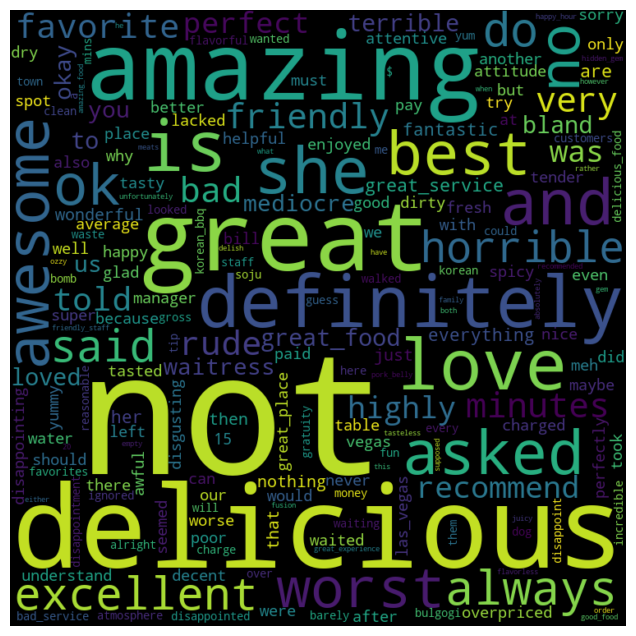

In [34]:
cloud(good_llr)

Using llr for good reviews, we can observe that these words are descriptive adjectives for positive experiences. Although, we can notice that it does capture some words that are associated with negative aspects.

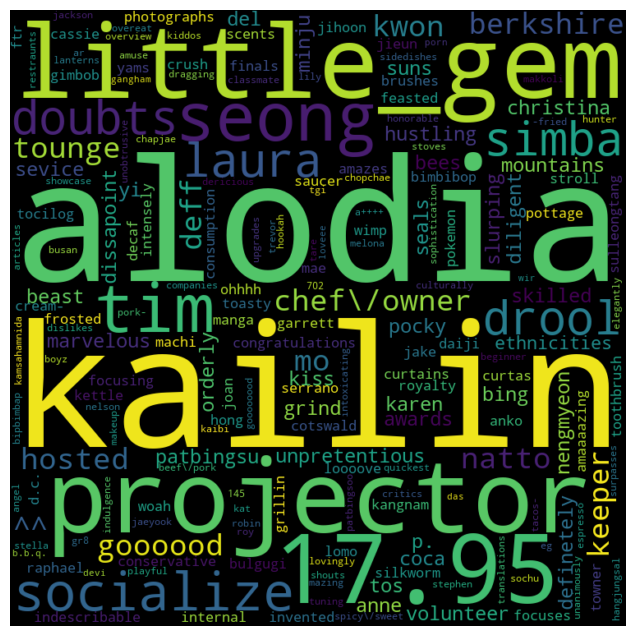

In [35]:
cloud(good_pmi)

Using pmi for good reviews, we can observe a lot of names of people and objects.

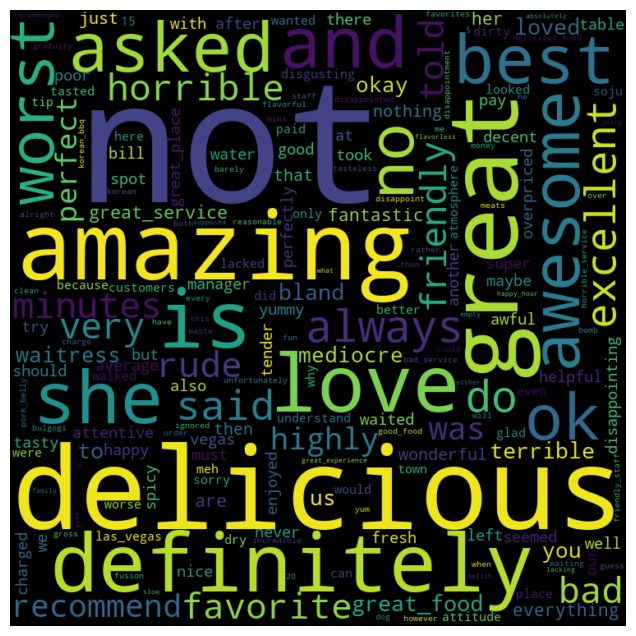

In [36]:
cloud(bad_llr)

Using llr for bad reviews, we can observe a mix of descriptive adjectives that describe both positive and negative aspects. This is interesting because it is common for people to use positive words in a negative context when they are being sarcastic. This can definitely be a problem for our model later on. 

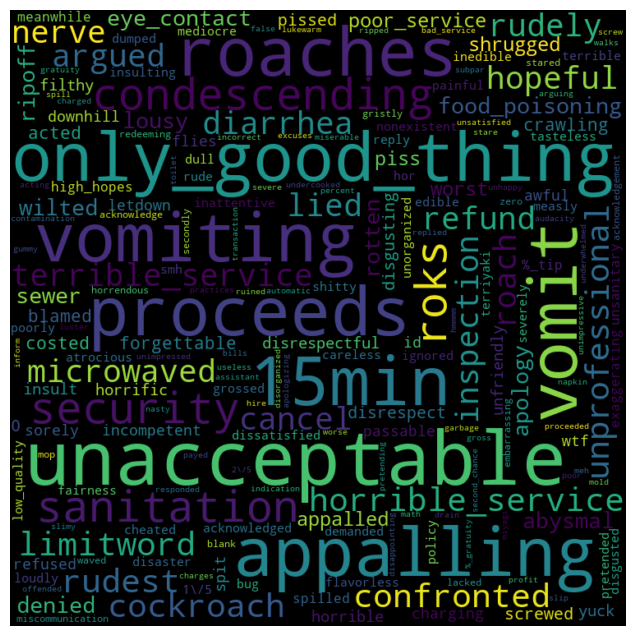

In [37]:
cloud(bad_pmi)

The word cloud generated using PMI for bad reviews reveals valuable insights that can serve as actionable recommendations for restaurant owners.

## Sentiment Analysis & SGD Classifier

In [38]:
#create a training and testing set.
train, test = train_test_split(
    krn, test_size=0.1, stratify=krn["sentiment"], random_state=123
)

Since we are interested in creating a model that can classify the review as positive or negative we will utilize the SGD classifier with the hinge loss function. This  is a linear function that enables the separation of data points into distinct groups.

In [39]:
m1 = make_pipeline(
    CountVectorizer(),
    TfidfTransformer(),
    SGDClassifier(random_state=1),
)

m1.fit(train["docs"].apply(lambda x: ' '.join(x)), train["sentiment"])
print(classification_report(test["sentiment"], m1.predict(test["docs"].apply(lambda x: ' '.join(x)))))

              precision    recall  f1-score   support

    negative       0.87      0.80      0.84      1112
    positive       0.92      0.95      0.94      2720

    accuracy                           0.91      3832
   macro avg       0.90      0.88      0.89      3832
weighted avg       0.91      0.91      0.91      3832



With the SGDClassifier, we achieved a macro average f1-score of 0.89. While we have the option to further improve performance through hyperparameter tuning using randomized search with cross-validation, we have decided to utilize this model going forward as it demonstrated strong performance. Our focus now shifts to interpreting the coefficients for deeper insights.

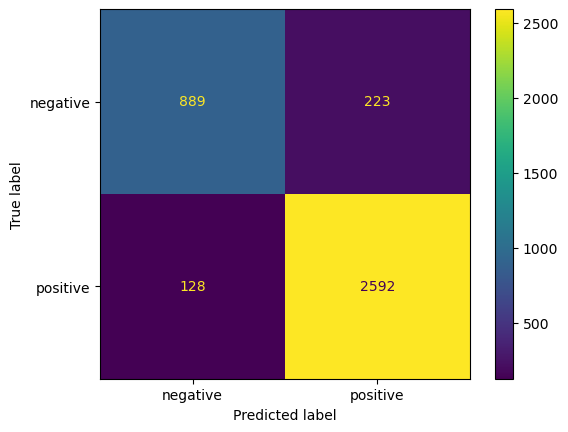

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(m1, test["docs"].apply(lambda x: ' '.join(x)), test["sentiment"])

The confusion matrix provides an effective visual representation of how the model performed in classifying our labels.

In [41]:
def get_top_feats(M, k=0):
    V = M.named_steps["countvectorizer"].get_feature_names_out()
    coef = M.named_steps["sgdclassifier"].coef_[0]
    order = coef.argsort()

    data = []
    for w1, w2 in zip(order[-k:][::-1], order[:k]):
        data.append({
            'Positive Feature': V[w1],
            'Positive Coefficient': coef[w1],
            'Negative Feature': V[w2],
            'Negative Coefficient': coef[w2]
        })

    df = pd.DataFrame(data)
    return df

Let's create a function to help us extract the feature names and its associated coefficients. This will help us identify which words had a positive or negative impact in the classification task.

In [42]:
top_feats_df = get_top_feats(m1, 100)

In [43]:
top_feats_df.iloc[0:50]

,Positive Feature,Positive Coefficient,Negative Feature,Negative Coefficient
0,delicious,5.086681,not,-5.260779
1,great,3.743624,ok,-4.115460
2,amazing,3.613450,mediocre,-3.882410
3,love,3.457737,worst,-3.744903
4,definitely,3.278251,okay,-3.421438
5,excellent,3.235259,bland,-3.414679
6,awesome,3.206859,average,-3.302423
7,best,3.172035,horrible,-2.988371
8,perfect,2.642793,terrible,-2.806647
9,loved,2.629039,meh,-2.752893


Upon examination, it's apparent that a considerable number of words are simple adjectives that merely describe positive or negative sentiments. To gain more meaningful insights, we will proceed by excluding these adjective words from further analysis.

In [44]:
words_to_drop =  ['not','ok','worst','okay','horrible', 'mediocre',
                'terrible','meh','no', 'disappointing', 'mbe',
                'nothin', 'lacked', 'poor', 'ay', 'average',
                'decent', 'alright', 'awful', 'hing', 'asked',
                'however', 'barely', 'disappointed', 'tasted',
                'sucks', 'lacking', 'rather', 'elsewhere',
                'maybe', 'worse', 'sorry', 'bad', 'should',
                'unfortunately', 'seemed', 'said', 'guess']

original_df = get_top_feats(m1, 42)

modified_df = original_df.copy()

for word in words_to_drop:
    modified_df['Negative Feature'] = modified_df['Negative Feature'].str.replace(word, '')

modified_df = modified_df[modified_df['Negative Feature'].str.strip().astype(bool)]
modified_df = modified_df.reset_index(drop=True)

print(modified_df[['Negative Feature', 'Negative Coefficient']])

   Negative Feature  Negative Coefficient
0             bland             -3.414679
1        overpriced             -2.704230
2               dry             -2.427649
3              rude             -2.355188
4             dirty             -1.841249
5               mbe             -1.711080
6    food_poisoning             -1.637885
7             salty             -1.629367
8             gross             -1.613718
9        disgusting             -1.613298
10             slow             -1.607852


We can see that after the removal, we can see words that describe their negative experiences with the food, price, cleaniness and service. More specifically, customers do not like when their food is bland, dry, salty, or causes food poisoning. They also do not like slow or rude service, overpriced items, and dirty establishments. Similarly, the positive features describe positive experiences of food, price, cleaniness and service. Let's pick a restaurant that might need some assistance and apply the same methods.

In [45]:
krn[krn["review_star"] < 4]["name"].value_counts().head(20)

Noodles                                       499
Gen Korean BBQ House                          445
Pei Wei                                       299
Gangnam Asian BBQ Dining                      291
Tofu Hut                                      259
KoMex Fusion                                  251
Lulu's Noodles                                240
Genghis Grill                                 234
Sura BBQ Buffet                               227
Honey Pig                                     218
Dae Jang Keum Korean BBQ & Tofu Restaurant    212
Buffet Asia                                   211
Lee's Korean BBQ                              194
Ohya Sushi, Korean Kitchen & Bar              191
Hwaro                                         182
Bonchon Chicken                               179
Pei Wei Asian Diner                           173
Soyo Korean Barstaurant                       171
Mother's Korean Grill                         168
Ginseng Korean BBQ II                         164


Let's help this restaurant called Noodles as it has the most number of reviews that are under 4 stars.

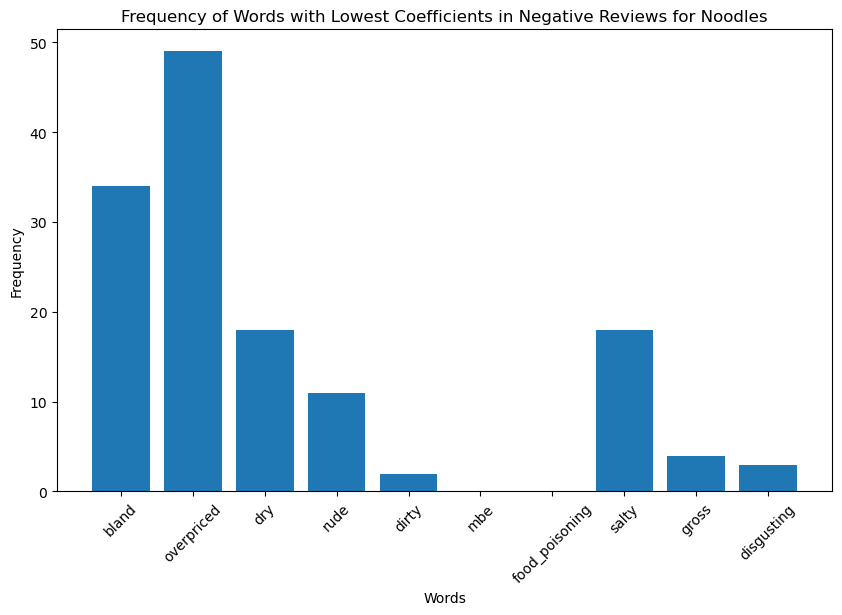

In [46]:
filtered_df = krn[(krn["review_star"] < 4) & (krn["name"] == "Noodles")]

word_freq = {}

for index, review in filtered_df.iterrows():
    words = review["text"].lower().split()
    for word in words:
        if word not in word_freq:
            word_freq[word] = 1
        else:
            word_freq[word] += 1

lowest_coef_words = modified_df.nsmallest(10, "Negative Coefficient")["Negative Feature"]

plt.figure(figsize=(10, 6))
plt.bar(lowest_coef_words, [word_freq.get(word, 0) for word in lowest_coef_words])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of Words with Lowest Coefficients in Negative Reviews for Noodles')
plt.xticks(rotation=45)
plt.show()

Based on the analysis of negative reviews for the restaurant "Noodles," it becomes evident that customers commonly express dissatisfaction with regards to two main aspects: bland taste and high prices. An important recommendation is for the restaurant "Noodles" to conduct a thorough evaluation of their pricing strategy in comparison to similar establishments. Ensuring competitive pricing will enhance customer satisfaction and attract more patrons. Additionally, it is crucial for the restaurant to focus on maintaining consistency in their cooking methods to deliver consistently flavorful dishes. Considering recipe adjustments can also be beneficial in achieving higher-quality, more enjoyable food for their customers.